# Paper

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [40]:
global MAX_DISTANCE
MAX_DISTANCE = 10000

class Poisson:
    def __init__(self, arrival_rate, t_limit=4000, seed=0):
        self.seed = seed
        self.t_limit = t_limit
        self.arrival_rate = arrival_rate
        self.arrivals = self.__sim()
        self.intervals = self.__interval_split()
        self.last_offset = -1

    def next(self, offset=1):
        """Get next instances per second.
        Example: first next() should return the arrivals between [0, 0 + offset)."""
        self.last_offset += offset
        if self.last_offset == len(self.intervals):
            raise AttributeError

        return self.intervals[self.last_offset]

    def reset(self):
        self.last_offset = -1

    def __interval_split(self, offset=1):
        acc = offset
        bucket = []
        intervals = []
        for x in self.arrivals:
            if x < acc:
                bucket.append(x)
            else:
                intervals.append(bucket)
                bucket = [x]
                acc += offset
                while x > acc:
                    acc += offset
                    intervals.append([])

        # last bucket
        intervals.append(bucket)

        return intervals

    def __sim(self):
        t_acum = 0
        num = self.seed
        aux = []
        while t_acum <= self.t_limit:
            num = RandomNumber.next(num)
            z = self.__exponential(num)
            t_acum += z
            aux.append(t_acum)

        return aux

    def __exponential(self, num):
        return - np.log(num / RandomNumber.MODULE) / self.arrival_rate


class ObjectArrival(Poisson):
    def __init__(self, arrival_rate, t_limit, seed):
        super().__init__(arrival_rate, t_limit, seed)
        self.velocity_calculator = VelocityCalculator()

    def map_object(self, x):
        raise NotImplementedError("Please Implement this method")

    def next(self, offset=1):
        return list(map(lambda x: self.map_object(x), super().next()))


class CarArrival(ObjectArrival):
    def __init__(self, arrival_rate, t_limit=4000, seed=0):
        super().__init__(arrival_rate, t_limit, seed)

    def map_object(self, x):
        return Car(Position(-1, -1), 10)


class PedestrianArrival(ObjectArrival):
    def __init__(self, arrival_rate, t_limit=4000, seed=0):
        super().__init__(arrival_rate, t_limit, seed)

    def map_object(self, x):
        return Pedestrian(Position(-1,-1), self.velocity_calculator.next(RandomNumber.get(x)))


class RandomNumber:
    MODULE = 4294967296
    MULTIPLIER = 1013904223
    INCREMENT = 1664525

    @classmethod
    def next(cls, n):
        return (cls.MULTIPLIER * n + cls.INCREMENT) % cls.MODULE

    @classmethod
    def get(cls, n):
        return cls.next(n) / cls.MODULE


class VelocityCalculator:
    VALUES = [2, 3, 4, 5, 6]
    P = [2730 / 10000, 5200 / 10000, 1370 / 10000, 480 / 10000, 220 / 10000]

    def __init__(self):
        p = VelocityCalculator.P
        self.proba_vector = [
            0, p[0], p[0] + p[1], p[0] + p[1] + p[2], p[0] + p[1] + p[2] + p[3], p[0] + p[1] + p[2] + p[3] + p[4]
        ]

    def next(self, n):
        label_idx = 0
        for idx in range(0, len(self.proba_vector) - 1):
            if (n >= self.proba_vector[idx]) and (n <= self.proba_vector[idx + 1]):
                label_idx = idx
        return VelocityCalculator.VALUES[label_idx]


class Position:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def x(self):
        return self.x
    
    def y(self):
        return self.y
    
    def is_negative(self):
        return (self.x < 0) | (self.y < 0)
    
    def __eq__(self, other):
        return (self.x == other.x) & (self.y == other.y)
    
    def __hash__(self):
        return hash(tuple([self.x, self.y]))

class Pedestrian:
    def __init__(self, position, velocity):
        self.position = position
        self.direction = 'right'
        self.velocity = velocity
        self.next_position = None
       
    def set_in_matrix(self, matrix):
        matrix.put(self.position.x, self.position.y, self) 
            
            
    def avanzar(self, matrix, semaforo):
        if semaforo.is_red():
            if self.position.is_negative(): # no empieza a cruzar
                return
        
            # Semaforo rojo y estaba cruzando, avanza a maxima velocidad
            if self.direction == 'right':
                self.next_position = Position(self.position.x + 6, self.position.y)
            elif self.direction == 'left':
                self.next_position = Position(self.position.x - 6, self.position.y)
            
            return self.next_position
        
        else:  # Semaforo verde
            if self.position.is_negative(): # no empieza a cruzar
                self.locate(matrix)
                
            self.move_forward(matrix) 
            if not self.next_position:  # Posicion ocupada
                self.lane_change(matrix)
            return self.next_position
        
            
    # Establece su posicion y direccion inicial
    def locate(self, matrix):
        # cambiar por posiciones al azar
        height = matrix.get_height()
        width = matrix.get_width()
        pos_y = np.random.randint(height - 1)
        if (np.random.rand() < 0.5):
            self.direction = 'right'
            self.position = Position(0, pos_y)
        else:
            self.direction = 'left'             
            self.position = Position(width - 1, pos_y)
            
        
    def continuar(self, matrix):
        matrix.put(self.position.x, self.position.y, None)
        self.position = self.next_position
        self.next_position = None
        matrix.put(self.position.x, self.position.y, self)

        
        
    def move_forward(self, matrix):
        if self.direction == 'right':
            direction = 1
        elif self.direction == 'left':
            direction = -1
        d = matrix.distance_to_next_object(self.position.x, self.position.y, direction)
        
        if d == 0:  # la siguiene posicion esta ocupada
            return None

        self.next_position = Position(self.position.x + self.velocity * direction, self.position.y)
        self.update_velocity(direction, matrix)
        
        
    def update_velocity(self, direction, matrix):
        d = matrix.distance_to_next_object(self.next_position.x, self.position.y, direction)
        self.velocity = min(d, self.velocity)
        

    def lane_change(self, matrix):
        if self.direction == 'right':
            direction = 1
        elif self.direction == 'left':
            direction = -1

        d = matrix.distance_to_next_object(self.position.x, self.position.y, direction)
        if d != 0: 
            return
        if self.can_turn_right(matrix) & self.can_turn_left(matrix):
            if (np.random.rand() < 0.5):
                self.turn_right()
            else:
                self.turn_left()
        elif self.can_turn_right(matrix):
            self.turn_right()
        elif self.can_turn_left(matrix):
            self.turn_left()
            
    
    def turn_right(self):
        self.next_position = Position(self.position.x, self.position.y + 1)
    
    def turn_left(self):
        self.next_position = Position(self.position.x, self.position.y - 1)
        
                                      
    def can_turn_right(self, matrix):
        return (matrix.is_empty(self.position.x, self.position.y + 1)) & \
               (self.velocity_higher_than_last(self.position.y + 1, matrix)) & \
               (self.velocity_less_than_next(self.position.y + 1, matrix))
                                      
    def can_turn_left(self, matrix):
        return (matrix.is_empty(self.position.x, self.position.y - 1)) & \
               (self.velocity_higher_than_last(self.position.y - 1, matrix)) & \
               (self.velocity_less_than_next(self.position.y - 1, matrix))
        
    def velocity_higher_than_last(self, position_y, matrix):
        if self.direction == 'right':
            direction = -1
        elif self.direction == 'left':
            direction = 1
        last_pedestrian = matrix.get_next_object(self.position.x, position_y, direction)
        
        if not last_pedestrian:  # nadia camina atras
            return True
        return self.velocity > last_pedestrian.velocity    
                
    def velocity_less_than_next(self, position_y, matrix):
        if self.direction == 'right':
            direction = 1
        elif self.direction == 'left':
            direction = -1
        distance = matrix.distance_to_next_object(self.position.x, position_y, direction)
        return self.velocity < distance
 
    def is_pedestrian(self):
        return True
                
    def finished(self, matrix):
        if self.direction == 'right':
            return self.position.x >= matrix.get_width()
        return self.position.x < 0
    
    def __str__(self):
        return 'Pos {0} Vel {1}'.format(self.position, self.velocity)


class Car:
    def __init__(self, position, velocity):
        self.size_x = 6
        self.size_y = 5
        self.velocity = 10 # 5 m/s * 2 cell/m
        self.initial_pos = position
        self.positions = []
        self.started = False
        
    def set_in_matrix(self, matrix):
        if not self.started:
            return
        for i in range(0, self.size_x):
            for j in range(0, self.size_y):
                matrix.put(self.positions[i][j].x, self.positions[i][j].y, self)
                
    def del_in_matrix(self, matrix):
        for i in range(0, self.size_x):
            for j in range(0, self.size_y):
                matrix.put(self.positions[i][j].x, self.positions[i][j].y, None)
        
        
    def avanzar(self, matrix, semaforo):
        if semaforo.is_green(): 
            return 0
        
        if not self.started: # no empezo a cruzar
            self.locate(matrix)
        
        conflict = 0
        if not matrix.pedestrian_on_crosswalk():
            distance = self.velocity
        else:
            distance = min(self.distance_to_pedestrian(matrix), self.velocity)
            if distance < self.velocity:
                conflict = 1
            
        self.move(distance, matrix)
        return conflict
        
    
    def locate(self, matrix):
        self.started = True
        pos_0_x = np.random.randint(matrix.get_width() // self.size_x) * self.size_x
        self.initial_pos = Position(pos_0_x, -self.size_y)
        for i in range(0, self.size_x):
            self.positions.append([])
            for j in range(0, self.size_y):
                self.positions[i].append(Position(self.initial_pos.x + i, self.initial_pos.y + j))
        
        
    def distance_to_pedestrian(self, matrix):
        distance = MAX_DISTANCE
        # Recorro todas las celdas del camino del auto para encontrar la distancia al primer peaton
        for j in range(0, self.size_x):  
            pos_x = self.initial_pos.x + j
            pos_y = self.initial_pos.y + self.size_y - 1
            d = matrix.distance_car_to_pedestrian(pos_x, pos_y)
            if d < distance:
                distance = d
        return distance
            
        
    def move(self, distance, matrix):
        self.initial_pos = Position(self.initial_pos.x, self.initial_pos.y + distance)
        self.del_in_matrix(matrix)
        for i in range(0, self.size_x):
            for j in range(0, self.size_y):
                self.positions[i][j] = Position(self.positions[i][j].x, self.positions[i][j].y + distance)
        self.set_in_matrix(matrix)
        
        
    def is_pedestrian(self):
        return False
        
    def finished(self, matrix):
        return self.initial_pos.y > matrix.get_height() 
    
    def __str__(self):
        return 'Pos {0} Vel {1}'.format(self.position, self.velocity)

class Matrix:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        
        self.matrix = []
        for i in range(0, width):
            self.matrix.append([])
            for j in range(0, height):
                self.matrix[i].append(None)

        
    def put(self, position_x, position_y, object):
        if ((position_x < 0) | (position_x >= self.width)) | \
           ((position_y < 0) | (position_y >= self.height)):
            return 
        self.matrix[position_x][position_y] = object
        
    def is_empty(self, position_x, position_y):
        if ((position_x < 0) | (position_x >= self.width)) | \
           ((position_y < 0) | (position_y >= self.height)):
            return False
        return self.matrix[position_x][position_y] == None
        
    # distancia horizontal
    def distance_to_next_object(self, position_x, position_y, direction):
        position_x += direction
        distance = 0
        if (0 > position_y) | (position_y >= self.height):
            return MAX_DISTANCE
        while ((0 <= position_x) & (position_x < self.width)) & (distance < MAX_DISTANCE):
            if self.matrix[position_x][position_y] != None:
                return distance
            distance += 1
            position_x += direction
        return MAX_DISTANCE
            
    # distancia horizontal
    def get_next_object(self, position_x, position_y, direction):
        position_x += direction
        distance = 0
        if (0 > position_y) | (position_y >= self.height):
            return None
        while ((0 <= position_x) & (position_x < self.width)) & (distance < MAX_DISTANCE):
            if self.matrix[position_x][position_y] != None:
                return self.matrix[position_x][position_y]
            distance += 1
            position_x += direction
        return None
    
    # distancia vertical
    def distance_car_to_pedestrian(self, position_x, position_y):
        position_y += 1
        distance = 0
        while ((0 <= position_y) & (position_y < self.height)) & (distance < MAX_DISTANCE):
            if self.matrix[position_x][position_y] != None:
                return distance
            distance += 1
            position_y += 1
        return MAX_DISTANCE
    
    def pedestrian_on_crosswalk(self):
        for i in range(0, self.width):
            for j in range(0, self.height):
                if not self.matrix[i][j]:
                    continue
                if self.matrix[i][j].is_pedestrian():
                    return True
        return False
    
    def get(self):
        for i in range(0, self.width):
            print()
            for j in range(0, self.height):
                if not self.matrix[i][j]:
                    print('0', end=' ')
                elif self.matrix[i][j].is_pedestrian():
                    print('1', end=' ')
                else:
                    print('2', end=' ')
                    
                    
    def get_height(self):
        return self.height
    
    def get_width(self):
        return self.width

class State:

    street_cell = 50
    waiting_area = 99
    pedestrian_cell = 90
    car_cell = 20

    def __init__(self, semaforo_t_verde, semaforo_t_rojo):
        self.cars = []
        self.pedestrians = []
        self.crossroad_width = 62
        self.crossroad_height = 20
        #self.semaforo_tiempo_verde = 10
        #self.semaforo_tiempo_rojo = 20
        self.semaforo_tiempo_verde = semaforo_t_verde
        self.semaforo_tiempo_rojo = semaforo_t_rojo
        self.nro_iteracion = 0
        self.cantidad_iteraciones = 100
        self.semaforo = Semaforo(self.semaforo_tiempo_verde, self.semaforo_tiempo_rojo)
        
        #llegada_peatornes = Poisson 
        self.pedestrian_arrival = PedestrianArrival(0.9)
        
        #llegada_vehiculos = Poisson 
        self.car_arrival = CarArrival(0.5)
        
        
        self.conflicto_peatones_misma_pos = 0
        self.conflicto_auto_espera_peaton = 0
    
    def valid_pos(self, x, y, width, height):
        if(x >= 0 and x < width and y >= 0 and y < height):
            return True
        return False  
        
    def iterar(self):

        # llegada de peatones
        self.pedestrians += self.pedestrian_arrival.next()
        
        # llegada de autos
        self.cars += self.car_arrival.next()
        
        #avanzar de estado el semaforo
        self.semaforo.iterar(1)
        
        self.matriz = self.get_positions_matrix()    
        
        proximas_posiciones = {}
        # Avanzo peatones               
        for peaton in self.pedestrians:
            # Debería devolver conflictos peaton espera auto
            proxima_posicion = peaton.avanzar(self.matriz, self.semaforo)
            if not proxima_posicion:
                continue
            
            if proxima_posicion not in proximas_posiciones:
                proximas_posiciones[proxima_posicion] = peaton
            else: # dos peatones quieren ir a la misma posicion
                self.conflicto_peatones_misma_pos += 1
                if (np.random.rand() < 0.5): # con probabilidad 0.5 gana el segundo peaton
                    proximas_posiciones[proxima_posicion] = peaton
            
            if peaton.finished(self.matriz):
                self.pedestrians.remove(peaton)
         
        for peaton in proximas_posiciones.values():
            peaton.continuar(self.matriz)
            
            
        # Avanzo autos
        for car in self.cars:
            # Debería devolver confflictos de tipo auto espera peaton (1)
            conflicto = car.avanzar(self.matriz, self.semaforo)
            if conflicto:
                self.conflicto_auto_espera_peaton += conflicto
                
            if car.finished(self.matriz):
                self.cars.remove(car)
                
                
    def conflicto_peatones(self):
        return self.conflicto_peatones_misma_pos
                 
    def conflicto_autos(self):
        return self.conflicto_auto_espera_peaton      

        
    def __str__(self):
        return 'Iteracion {0}'.format(self.nro_iteracion)
    
    def get_matrix(self):
        ''' Devuelve la matriz lista para ser dibujada'''
        self.matriz = self.get_positions_matrix()
        return self.matriz.get()
    
    def get_positions_matrix(self):
        m = Matrix(self.crossroad_width, self.crossroad_height)
            
        for pedestrian in self.pedestrians:
            pedestrian.set_in_matrix(m)
            
        for car in self.cars:
            car.set_in_matrix(m)
            
        return m

    def semaforo_matrix(self):
        return self.semaforo.matrix()


    def matrix(self):
        
        w = self.crossroad_width
        h = self.crossroad_height
        
        matrix = np.array([[self.street_cell for number in range(h) ] for i in range(w)])
                
        for pedestrian in self.pedestrians:
            if(self.valid_pos(pedestrian.position.x, pedestrian.position.y, w, h)):
                matrix[pedestrian.position.x, pedestrian.position.y] = self.pedestrian_cell
        for car in self.cars:
            for l in car.positions:
                for p in l:
                    if(self.valid_pos(p.x, p.y, w, h)):
                        matrix[p.x, p.y] = self.car_cell
        return matrix

class Semaforo:
    def __init__(self, tiempo_verde, tiempo_rojo):
        self.estado = 'verde'
        self.timer = 0
        self.tiempo_verde = tiempo_verde
        self.tiempo_rojo = tiempo_rojo
    
    def iterar(self, t):
            self.timer += 1
            if(self.estado == 'verde' and self.timer > self.tiempo_verde):
                self.timer = 0
                self.estado = 'rojo'
                
            elif(self.estado == 'rojo' and self.timer > self.tiempo_rojo):
                self.timer = 0
                self.estado = 'verde'

    def matrix(self):
        traffic_light_green = 4
        traffic_light_red = 2
        if(self.is_red()):
            return np.array([[traffic_light_red],[0]])
        else:
            return np.array([[0],[traffic_light_green]])

    def is_red(self):
        return self.estado == 'rojo'
    
    def is_green(self):
        return self.estado == 'verde'
                
    def __str__(self):
        return 'Estado {0}'.format(self.estado)

In [52]:
t_verdes = [25, 30, 35, 40, 45, 50]
t_rojos = [65, 60, 55, 50, 45, 40]

matriz_conflictos_peatones = []
matriz_conflictos_autos = []
n = 0
for t_verde in t_verdes:
    matriz_conflictos_peatones.append([])
    matriz_conflictos_autos.append([])
    for t_rojo in t_rojos:
        state = State(t_verde, t_rojo)
        for i in range(0, 3600): # 1 hora
            state.iterar()
        matriz_conflictos_peatones[n].append(state.conflicto_peatones() // 60) # conflictos por minuto
        matriz_conflictos_autos[n].append(state.conflicto_autos() // 60) # conflictos por minuto
    n += 1

In [53]:
matriz_conflictos_peatones

[[688, 646, 569, 568, 525, 501],
 [873, 785, 787, 726, 671, 653],
 [1013, 939, 879, 854, 777, 817],
 [1151, 1119, 1069, 1034, 1089, 956],
 [1324, 1308, 1335, 1161, 1156, 1085],
 [1524, 1464, 1381, 1341, 1303, 1186]]

In [54]:
matriz_conflictos_autos

[[88, 91, 87, 89, 93, 96],
 [96, 101, 101, 98, 103, 101],
 [105, 108, 113, 111, 112, 120],
 [119, 118, 116, 126, 127, 119],
 [121, 141, 129, 134, 140, 137],
 [132, 139, 148, 138, 152, 158]]

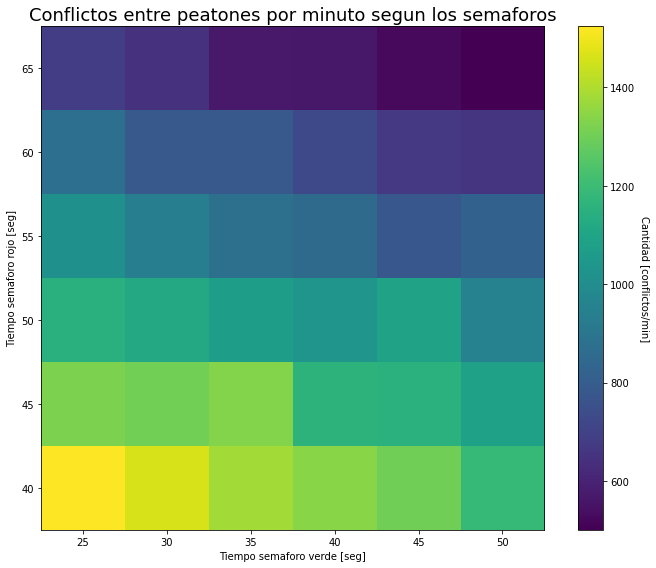

In [55]:
fig, ax = plt.subplots(figsize=(10,8))
im = ax.imshow(matriz_conflictos_peatones)

# We want to show all ticks...
ax.set_xticks(np.arange(len(t_verdes)))
ax.set_yticks(np.arange(len(t_rojos)))
# ... and label them with the respective list entries
ax.set_xticklabels(t_verdes)
ax.set_yticklabels(t_rojos)

ax.set_xlabel('Tiempo semaforo verde [seg]')
ax.set_ylabel('Tiempo semaforo rojo [seg]')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Cantidad [conflictos/min]', rotation=-90, va="bottom")

ax.set_title("Conflictos entre peatones por minuto segun los semaforos", fontsize=18)
fig.tight_layout()
plt.show()


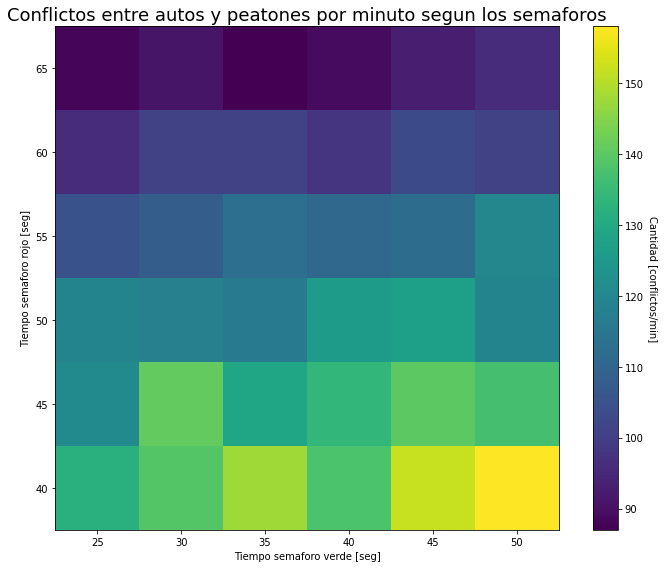

In [56]:
fig, ax = plt.subplots(figsize=(10,8))
im = ax.imshow(matriz_conflictos_autos)

# We want to show all ticks...
ax.set_xticks(np.arange(len(t_verdes)))
ax.set_yticks(np.arange(len(t_rojos)))
# ... and label them with the respective list entries
ax.set_xticklabels(t_verdes)
ax.set_yticklabels(t_rojos)

ax.set_xlabel('Tiempo semaforo verde [seg]')
ax.set_ylabel('Tiempo semaforo rojo [seg]')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Cantidad [conflictos/min]', rotation=-90, va="bottom")

ax.set_title("Conflictos entre autos y peatones por minuto segun los semaforos", fontsize=18)
fig.tight_layout()
plt.show()
